<a href="https://colab.research.google.com/github/Abby263/cv-projects/blob/main/JanataHack_CV_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [2]:
import zipfile
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [85]:
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).T 
        label = self.img_labels.iloc[idx, 1]
        if self.transform:    
            image = np.array(image)
            image = self.transform(image)
            image = np.array(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [86]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

In [87]:
training_data = CustomImageDataset('/content/train.csv','/content/images')

In [88]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([4, 224, 224, 3])
Labels batch shape: torch.Size([4])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


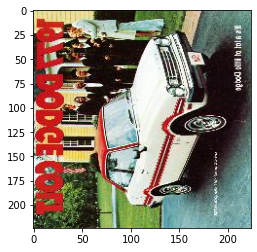

Label: 0


In [125]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_features[0].shape)
img = train_features[0].squeeze()
print(img.shape)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [181]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        # self.fc1 = nn.Linear(16 * 3 * 3, 160)
        # self.fc2 = nn.Linear(160, 84)
        # self.fc3 = nn.Linear(84, 2)
        self.fc1 = nn.LazyLinear(160)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

test_x= torch.randn(4,3,224,224)
net(test_x)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[0.0473, 0.0686],
        [0.0275, 0.0780],
        [0.0205, 0.0673],
        [0.0197, 0.0730]], grad_fn=<AddmmBackward0>)

In [182]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [190]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.permute(0,3, 1, 2).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,   201] loss: 0.068
[1,   401] loss: 0.068
[2,     1] loss: 0.000
[2,   201] loss: 0.067
[2,   401] loss: 0.067
Finished Training


In [196]:
df_test = pd.read_csv('/content/test.csv')
df_sub = pd.read_csv('/content/sample_submission.csv')

In [192]:
df_test.head(5)

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg


In [197]:
df_sub.head(5)

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [213]:
prediction_col = []
for i in df_test['image_names'] :
  img_path = '/content/images/'+i
  # print(img_path)
  # print(image.shape)
  image = read_image(img_path).T 
  # print(image.shape)
  image = image.permute(2,0, 1).float()
  image = image[None,:]
  outputs = net(image)
  # print(outputs)
  _, predicted = torch.max(outputs, 1)
  # print('Predicted :', predicted.item())
  prediction_col.append(predicted.item())
  

In [214]:
len(prediction_col)

706

In [215]:
df_test['emergency_or_not'] = prediction_col

In [219]:
df_test.to_csv('/content/output.csv',index=False)

In [217]:
df_test.head(5)

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [220]:
df_test['emergency_or_not'].value_counts()

0    702
1      4
Name: emergency_or_not, dtype: int64